Esse projeto tem como objetivo criar uma rede neural para conseguir inferir dados sobre um modelo especifo.
<br>O dataset é um conjunto de imagens de flores, totalizando 102 tipos diferentes.
<br>Dataset: [baixar o dataset](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip)
<br>Nesse projeto será realizado as seguintes ações:
* Carregar o dataset
* Obter os tipos diferentes de flores no dataset 
* Imprimir algumas imagens deste dataset
* Carregar uma rede reural pre treinada [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) e configurar o ouput conforme o dataset 
* Validar o % de acuracia do modelo pre treinado
* Treinar o modelo e salvar o melhor resultado
* Carregar o modelo e validar o % de acuracia
* Exibir a probabilidade do modelo acertar a imagem em um subconjunto de imagens.

In [17]:
# Imports here
import os
import numpy as np
import torch
import pandas as pd

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader,Dataset
import cv2
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


%matplotlib inline

## 1) Carregar o dataset

In [2]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((5005,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [3]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [4]:
#Para carregar é necessário que já o dataset encontre-se no mesmo diretorio que esse arquivo.

TRAIN_PATH = "dataset/dataset-train/train/"
TEST_PATH = "dataset/dataset-test/test/"
TRAINING_CSV_PATH ='dataset/train.csv'

df_train = pd.read_csv(TRAINING_CSV_PATH)

y, le = prepare_labels(df_train['Id'])

input_size = 224 
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

data_transforms =  transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),  # simple data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])

train_data = WhaleDataset(datafolder=TRAIN_PATH, datatype='train', df=df_train, transform=data_transforms, y=y)
test_data = WhaleDataset(datafolder=TEST_PATH, datatype='test', transform=data_transforms)
                             
# Batch_size é o numero de elementos que será carregado a cada iteração,
#isso serve para não carregar todos os dados de uma unica vez e deixar o treinamento do modelo muito lerdo.
batch_size = 32
num_workers=0

# Prepara os DataLoader

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)


## 2) Obter os tipos diferentes de flores no dataset

In [5]:
classes = df_train["Id"]
classes.value_counts().shape[0]
NUM_CLASSES = classes.value_counts().shape[0]
print(NUM_CLASSES)


5005


## 3) Imprimir algumas imagens deste dataset

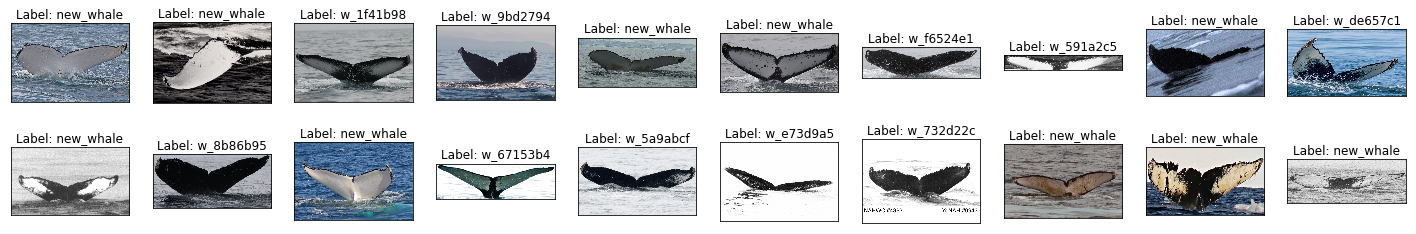

In [6]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir(TRAIN_PATH)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(TRAIN_PATH + img)
    plt.imshow(im)
    lab = df_train.loc[df_train.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

## 4) Carregar uma rede reural pre treinada [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) e configurar o ouput conforme o dataset 


In [7]:
#Nesse caso foi utilizado a rede resnet18 por não ser muito pesada e por conseguir fornecer um bom resultado nesse caso.
redeNeural = models.resnet18(pretrained=True)

### Configuração extra para habilitar GPU caso o PC possua.

In [8]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [9]:
##Alterar a quantidade de ouput conforme o dataset escolhido, nesse caso 102
from collections import OrderedDict
import torch.nn as nn
n_inputs = redeNeural.fc.in_features   
last_layer = nn.Linear(n_inputs, NUM_CLASSES)
redeNeural.fc = last_layer

## 5) Validar o % de acuracia do modelo pre treinado

In [10]:
#Antes de validar o modelo é preciso incluir o tipo de criterion e optimizer

import torch.optim as optim
redeNeural.cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(redeNeural.parameters(), lr=0.005)

## 6) Treinar o modelo e salvar o melhor resultado
Essa talvez seja a etapa mais importante do fluxo de treinamento do modelo.

In [11]:
# Epoch é algo semelhante a iteração no caso de ML(Machine Learning). 
# Quanto mais Epoch mais o modelo será treinado e terá um desempenho melhor. Mas é necessário tomar cuidado com Overfitting.
n_epochs = 3
globalLoss = 100;
redeNeural.cuda()
for epoch in range(1, n_epochs+1):

    # A perda de treino será incrementada a cada batch 
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for batch_i, (data, target) in enumerate(train_loader):

        ##Utilizar GPU caso esteja disponivel.
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = redeNeural(data)
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            train_loss_mean = train_loss / 20;
            print('Epoch %d, Batch %d loss: %.16f' % (epoch, batch_i + 1, train_loss_mean))
            if  train_loss_mean <= globalLoss:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                globalLoss,
                train_loss_mean))
                torch.save(redeNeural.state_dict(), 'model-saved.pth')
                globalLoss = train_loss_mean
            train_loss = 0.0

Epoch 1, Batch 20 loss: 0.0484366530494299
Validation loss decreased (100.000000 --> 0.048437).  Saving model ...
Epoch 1, Batch 40 loss: 0.0016018278780393
Validation loss decreased (0.048437 --> 0.001602).  Saving model ...
Epoch 1, Batch 60 loss: 0.0014151762821712
Validation loss decreased (0.001602 --> 0.001415).  Saving model ...
Epoch 1, Batch 80 loss: 0.0013575495220721
Validation loss decreased (0.001415 --> 0.001358).  Saving model ...
Epoch 1, Batch 100 loss: 0.0013579961727373
Epoch 1, Batch 120 loss: 0.0014089987205807
Epoch 1, Batch 140 loss: 0.0013797871652059
Epoch 1, Batch 160 loss: 0.0013426169287413
Validation loss decreased (0.001358 --> 0.001343).  Saving model ...
Epoch 1, Batch 180 loss: 0.0013757192587946
Epoch 1, Batch 200 loss: 0.0014175377204083
Epoch 1, Batch 220 loss: 0.0014225865452318
Epoch 1, Batch 240 loss: 0.0013251697295345
Validation loss decreased (0.001343 --> 0.001325).  Saving model ...
Epoch 1, Batch 260 loss: 0.0013591888127849
Epoch 1, Batch 2

## 7) Carregar o modelo e validar o % de acuracia

In [12]:
## Método para reccaregar o modelo já treinado
def _reload_module():
    redeNeural.load_state_dict(torch.load('model-saved.pth'))

In [13]:
'''
# Reccarega o modelo treinado.
_reload_module()
test_loss = 0.0
size = len(classes);

class_correct = list(0. for i in range(size))
class_total = list(0. for i in range(size))

redeNeural.eval() # prep model for evaluation
test_losses = []

for batch_i, (data, target, name) in enumerate(test_loader):
    # forward pass: compute predicted outputs by passing inputs to the model
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = redeNeural(data)
    # calculate the loss
    loss = criterion(output, target.float())
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except:
            print(target.size())
            print("Não foi encontrado o dataset de teste para a classe: ", classes[i])

redeNeural.train()
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
test_losses.append(test_loss/len(test_loader))
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
'''

'\n# Reccarega o modelo treinado.\n_reload_module()\ntest_loss = 0.0\nsize = len(classes);\n\nclass_correct = list(0. for i in range(size))\nclass_total = list(0. for i in range(size))\n\nredeNeural.eval() # prep model for evaluation\ntest_losses = []\n\nfor batch_i, (data, target, name) in enumerate(test_loader):\n    # forward pass: compute predicted outputs by passing inputs to the model\n    if train_on_gpu:\n        data, target = data.cuda(), target.cuda()\n    output = redeNeural(data)\n    # calculate the loss\n    loss = criterion(output, target.float())\n    # update test loss \n    test_loss += loss.item()*data.size(0)\n    # convert output probabilities to predicted class\n    _, pred = torch.max(output, 1)\n    # compare predictions to true label\n    correct = np.squeeze(pred.eq(target.data.view_as(pred)))\n    # calculate test accuracy for each object class\n    for i in range(batch_size):\n        try:\n            label = target.data[i]\n            class_correct[label

## 8) Exibir a probabilidade do modelo acertar a imagem em um subconjunto de imagens.

KeyError: tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

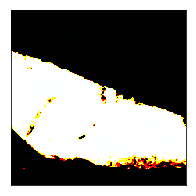

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels, name = dataiter.next()


# move model inputs to cuda, if GPU available
if train_on_gpu:
    imagesCuda = images.cuda()
    redeNeural.cuda()
output = redeNeural(imagesCuda)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
        
        
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
count = 0
fig = plt.figure(figsize=(37, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)).astype(np.uint8))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    if preds[idx].item()==labels[idx].item():
        count +=1
print("Acertos: ", count)

In [19]:
sub = pd.read_csv('dataset/sample_submission.csv')
_reload_module()
redeNeural.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = redeNeural(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission.csv', index=False)
print("csv created")


csv created


In [16]:
df_sample = pd.read_csv('submission.csv')
df_sample.head(10)

,Image,Id
0,00028a005.jpg,new_whale w_fd3e556 w_67b3af9 w_1ca9ab1 w_aabdf8c
1,000dcf7d8.jpg,new_whale w_9353e7c w_7e2eb3d w_6822dbc w_fd3e556
2,000e7c7df.jpg,new_whale w_9b5109b w_70d0b3c w_533f9ea w_67b3af9
3,0019c34f4.jpg,new_whale w_fd3e556 w_67b3af9 w_9353e7c w_1ca9ab1
4,001a4d292.jpg,new_whale w_9b5109b w_67b3af9 w_aabdf8c w_fd3e556
5,00247bc36.jpg,new_whale w_9b5109b w_67b3af9 w_70d0b3c w_533f9ea
6,0027089a4.jpg,w_7e2eb3d new_whale w_9353e7c w_c2a1bc4 w_6822dbc
7,002de4d94.jpg,new_whale w_aabdf8c w_67b3af9 w_9b5109b w_fd3e556
8,002f52f0c.jpg,new_whale w_9b5109b w_67b3af9 w_fd3e556 w_aabdf8c
9,002fd89d4.jpg,new_whale w_9b5109b w_aabdf8c w_67b3af9 w_533f9ea
